# Introduction

In the former part (the 1st one), we used dd and syscall-related static tracepoints
and dynamic probes to calculate their average overheads. The idea was
to measure the time needed by dd to perform 3 millions reads and 3
millions writes of 1 byte with and without tracepoints/probes enabled.

The benchmarks gave the following results on a basic core i7 Ivybridge:

* About 350ns for a static tracepoint;
* About 400ns for a dynamic probe.

In this second part, we will try to get an idea on the distribution of
the estimated values above:

* Is the tracepoint cost worth always 350ns or...
* ...most of the time it is worth 200ns but a few times it reaches
  many microseconds ?

This page will try to answer this question.

# Description of the test environment

The test environment is the same as the one of the former part:

In this document, the tests will be executed in the following enviromnent:

*Basic laptop machine:*

* CPU: Intel Core i7-3537U @ 2.00GHz (up to 3.10GHz) 1 CPU / 2 cores
  per CPU / 2 threads per core;
* RAM: 8GB;
* System: Arch (glibc-2.23)
* Cpufreq governor: performance: the pstate power scaling driver is
  used; so the CPU frequency cannot be statically set with a
  user-space tool.
```
# cpupower frequency-set -g performance
```

The environment has many accuracy flaws:

* With this Ivy Bridge processor, the time-stamp counter cannot be
  used to measure time in cycles; the CPU displays the flag
  "constant_tsc"; so, the TSC frequency is stable unlike with the
  on-demand adapted CPU frequency, the TSC cycles are not correlated
  with the CPU cycles anymore.
* The pstate power scaling driver does not enable user-space
  applications to set a constant CPU frequency.


The following workaround should be tested:
```
Kernel command line: ... intel_pstate=disable
Other CPUfreq driver to use: acpi-cpufreq
Other governor to use: userspace
Set a constant frequency value: cpupower frequency-set -f 2GHz
```

# Some basic statistics extracted from perf archives

The python package linux-perf-stats provides 2 python scripts to be
executed by perf: export-to-csv.py and export-to-hdfstore.py. Both
provides the same feature: serialize the perf events into a Pandas
Dataframe compatible format.

Here, we have used export-to-hdfstore.py:

```
# perf script -s ~/workspace/perf/linux-perf-stats/share/perf_python_scripts/export-to-hdfstore.py -i raw_syscalls_sys_enter.data output=raw_syscalls_sys_enter.h5
```

Once loaded thanks to the generated hdfstore file, the dataframe will
be processed so as to get some statistics. Thus, we will be able to
find out whether the average cost values calculated in the former
chapter are relevant.

## Pre-requisite python import code

In [2]:
import pandas as pd
import linux_perf_stats as lps

pd.options.display.float_format = '{:,.2f}'.format

%matplotlib inline
lps.configure_plots()

%load_ext autoreload
%autoreload 2

-c:7: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.



## Statistics for the case: static tracepoint raw_syscalls:sys_enter

Let's load the events into a dataframe and use Pandas for basic
statistics generation. Here is a plotting of a few tracepoint events
(only raw_syscalls__sys_enter) during a 10us period:

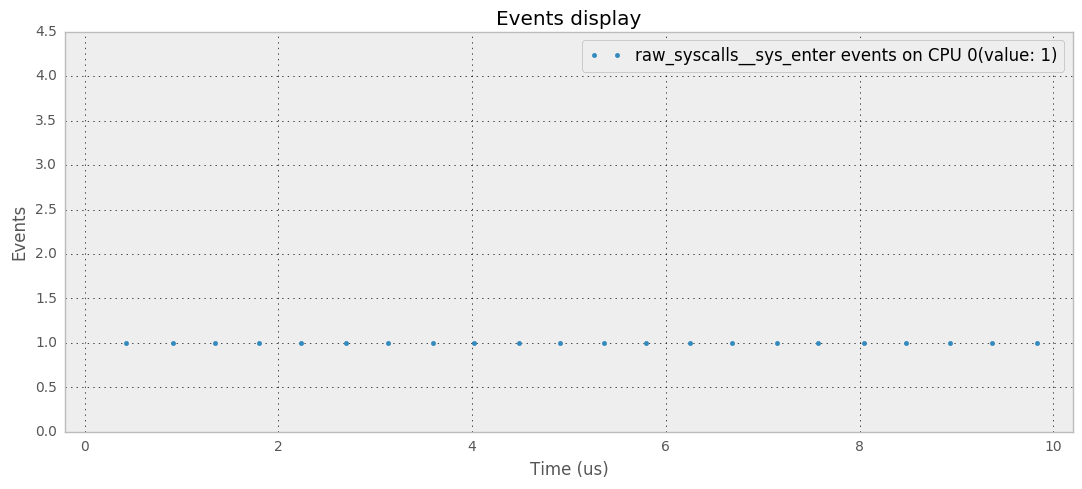

Recorded events:
   raw_syscalls__sys_enter


In [8]:
fname = '/home/alexis/workspace/perf/test_dd/raw_syscalls_sys_enter.h5'

# Read the DataFrame
store = pd.HDFStore(fname, mode='r')
df = store['events']
del store

# Many processes's events were recorded; keep only dd's events
df = df.loc[df.comm == 'dd']

print 'Recorded events:'
for event in df.event.unique():
    print '  ', event

lps.plot_event_timeline(df, offset='1ms', delay='10us')

Now, let's have a closer look thanks: calculate the time intervals
between 2 tracepoints and display:

* A statistics summary;
* A percentile graphic;

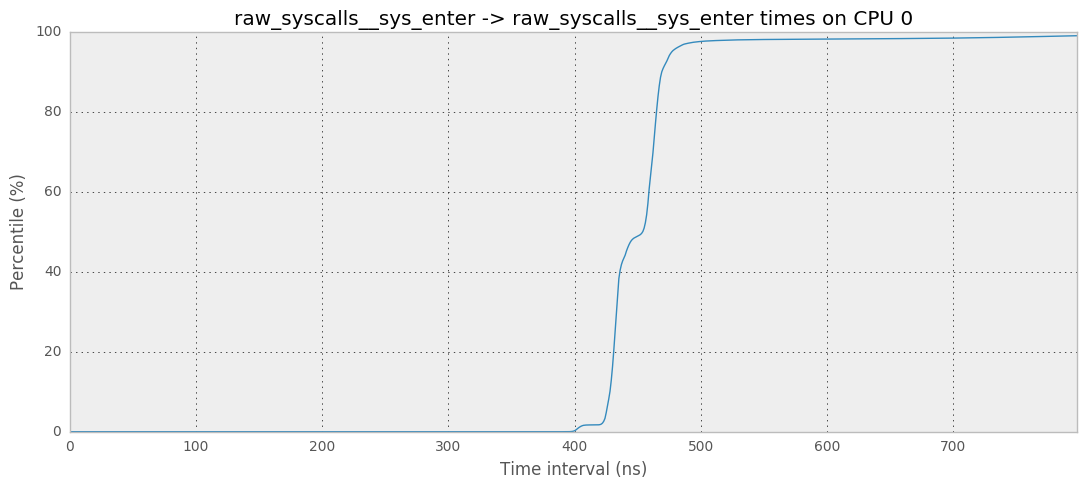

count   6,000,056.00
mean          458.39
std           405.04
min             0.00
25%           433.00
50%           454.00
75%           464.00
max       101,887.00
Name: duration, dtype: float64


Time interval statistics from raw_syscalls__sys_enter to raw_syscalls__sys_enter :
CPU 0


In [4]:
lps.print_event_intervals(df, 'raw_syscalls__sys_enter', 'raw_syscalls__sys_enter')
lps.plot_event_intervals(df, 'raw_syscalls__sys_enter', 'raw_syscalls__sys_enter')

### Interpretation

The first graphic above has no real interest; it just shows that the
tracepoint events occurences seem regular. If the events are nicely
distributed, it may mean that the cost of the tracepoints
raw_syscalls__sys_enter is constant.

However, the statistics summary above may prove this impression as
wrong. The standard deviation of time intervals between 2 syscalls
(405ns) nearly matches the average value (458ns). So, during a 2
seconds period, the delay between 2 syscalls is not stable.

Here are the reasons which might explain why:

* The dd process may have been preempted between 2 tracepoint events;
* The cost of a tracepoint might not be constant, maybe very high in a
  few cases;
* The cost of read / write syscalls might not be constant too (it
  would be surprising but one never knows...).

As the goal of this page is to assess the cost of tracepoints, we are
particularly interested in the second explanation.

So, in the next section, we will try to check the first hypothesis: "the
delay between 2 tracepoints is not constant because of preemption". If
the preemption does not explain all the variations, we may have to
consider the second alternative (we decided to consider the third
alternative as nearly impossible... so far).

## Statistics for the case: static tracepoint raw_syscalls:sys_enter + any preemption-related tracepoints

The perf command below was used to record the raw_syscalls:sys_enter
tracepoints and all the irq, irq_vectors, exceptions and sched
tracepoints during the execution of dd.

Here is the perf + dd command:

```
# perf record \
     -e raw_syscalls:sys_enter \
     -e irq_vectors:call_function_entry \
     -e irq_vectors:call_function_exit \
     -e irq_vectors:call_function_single_entry \
     -e irq_vectors:call_function_single_exit \
     -e irq_vectors:deferred_error_apic_entry \
     -e irq_vectors:deferred_error_apic_exit \
     -e irq_vectors:error_apic_entry \
     -e irq_vectors:error_apic_exit \
     -e irq_vectors:local_timer_entry \
     -e irq_vectors:local_timer_exit \
     -e irq_vectors:reschedule_entry \
     -e irq_vectors:reschedule_exit \
     -e irq_vectors:spurious_apic_entry \
     -e irq_vectors:spurious_apic_exit \
     -e irq_vectors:thermal_apic_entry \
     -e irq_vectors:thermal_apic_exit \
     -e irq_vectors:threshold_apic_entry \
     -e irq_vectors:threshold_apic_exit \
     -e irq_vectors:x86_platform_ipi_entry \
     -e irq_vectors:x86_platform_ipi_exit \
     -e "irq:*" \
     -e "exceptions:*" \
     -e "sched:*" \
     -o raw_syscalls_sys_enter_and_more2.data \
     -- bash -c "time dd if=/dev/zero of=/dev/null bs=1 count=3000000"

# Non-working tracepoints
#     -e irq_vectors:irq_work_entry
#     -e irq_vectors:irq_work_exit
```

Here is the perf command to generate an hdfstore file starting from
the perf archive (containing the tracepoints).

So, let's load the hdfstore file into a Pandas dataframe.


In [10]:
fname = '/home/alexis/workspace/perf/test_dd/raw_syscalls_sys_enter_and_more2.h5'

# Read the DataFrame
store = pd.HDFStore(fname, mode='r')
df = store['events']
del store

# Many processes's events were recorded; keep only dd's events
df = df.loc[df.comm == 'dd']

print 'Recorded events:'
for event in df.event.unique():
    print '  ', event

Recorded events:
   exceptions__page_fault_kernel
   sched__sched_process_exec
   exceptions__page_fault_user
   raw_syscalls__sys_enter
   irq_vectors__local_timer_entry
   irq__softirq_raise
   sched__sched_stat_runtime
   irq_vectors__local_timer_exit
   irq__softirq_entry
   irq__softirq_exit
   sched__sched_waking
   sched__sched_migrate_task
   sched__sched_stat_sleep
   sched__sched_wake_idle_without_ipi
   sched__sched_wakeup
   irq_vectors__reschedule_entry
   irq_vectors__reschedule_exit
   sched__sched_switch
   irq__irq_handler_entry
   irq__irq_handler_exit
   sched__sched_stat_wait
   sched__sched_process_exit


Let's check the statistics are still "bad" (which means the time
interval between 2 tracepoints varies significantly). The standard
deviation is still high.

In [6]:
# With the keyword argument 'filter' set to true, we will remove all
# events except 'raw_syscalls__sys_enter'; thus, we will be able to
# calculate the delay between 2 'raw_syscalls__sys_enter' events which
# are not adjacent (separated by one or many other events)
lps.print_event_intervals(df, 'raw_syscalls__sys_enter', 'raw_syscalls__sys_enter', filter=True)

count          31,041.00
mean           96,656.34
std        16,889,031.02
min                 0.00
25%               743.00
50%               808.00
75%               850.00
max     2,975,587,333.00
Name: duration, dtype: float64


count   4,430,863.00
mean          502.26
std           286.68
min             0.00
25%           450.00
50%           477.00
75%           483.00
max       113,934.00
Name: duration, dtype: float64
CPU 2


count   1,538,152.00
mean          487.54
std           228.05
min             0.00
25%           453.00
50%           479.00
75%           484.00
max        78,330.00
Name: duration, dtype: float64
CPU 1


Time interval statistics from raw_syscalls__sys_enter to raw_syscalls__sys_enter :
CPU 0


Now we will focus on the periods of time during which high delays were
recorded. Let's focus on the events recorded on CPU 0 and find the
events just before a delay larger than 20us.

In [23]:
tmp_df = df.copy()
tmp_df.nsecs -= tmp_df.nsecs.iloc[0]
tmp_df = tmp_df.loc[tmp_df.cpu == 0]
tmp_df.reset_index(drop=True, inplace=True)
tmp_df = lps.helpers.filter_events(tmp_df, ('raw_syscalls__sys_enter', ))
tmp_df = lps.event_interval._add_intervals(tmp_df)
tmp_df = tmp_df.loc[(tmp_df.duration > 20000)]

print 'Events just before a delay > 20us:'
print tmp_df[['cpu', 'event', 'nsecs', 'duration']].reset_index(drop=True)

Events just before a delay > 20us:
    cpu                    event      nsecs  duration
0     0  raw_syscalls__sys_enter   26578460     34676
1     0  raw_syscalls__sys_enter  126653015     51477
2     0  raw_syscalls__sys_enter  226740899     49262
3     0  raw_syscalls__sys_enter  326828059     61705
4     0  raw_syscalls__sys_enter  343604954     78330
5     0  raw_syscalls__sys_enter  344746636     20951
6     0  raw_syscalls__sys_enter  426921538     56379
7     0  raw_syscalls__sys_enter  527007124     62205
8     0  raw_syscalls__sys_enter  627095293     63102
9     0  raw_syscalls__sys_enter  666979862     50127
10    0  raw_syscalls__sys_enter  727187135     50455
11    0  raw_syscalls__sys_enter  771426190     54250


Now we choose 2 cases (we will explain how we choose them later) and
let's plot the tracepoints recorded during the "high delay".

**First sample**: at 0.127s of the record start (126653015ns)

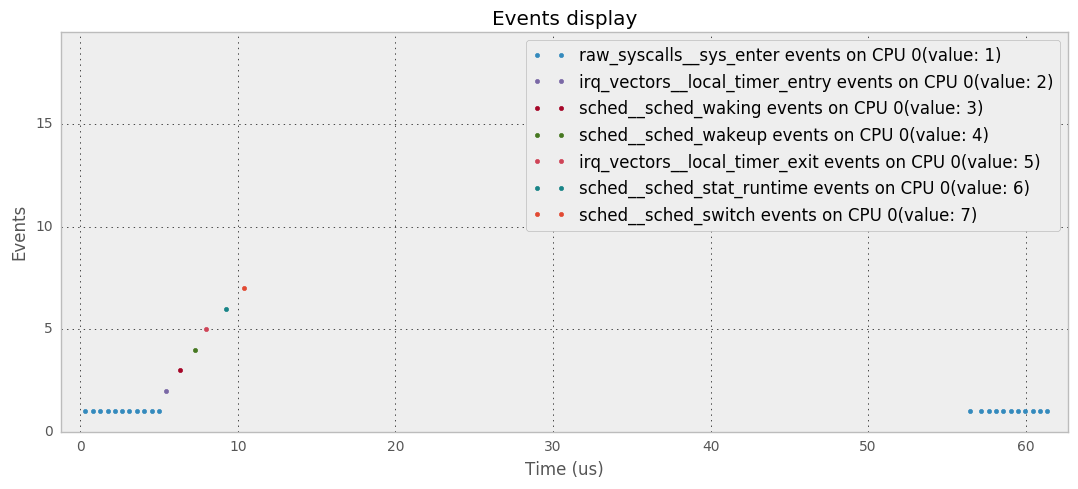

In [38]:
lps.plot_event_timeline(df, offset=(126653015 - 5000), delay=(51477 + 10000))

**Second sample**: at 0.345s of the record start (344746636ns)

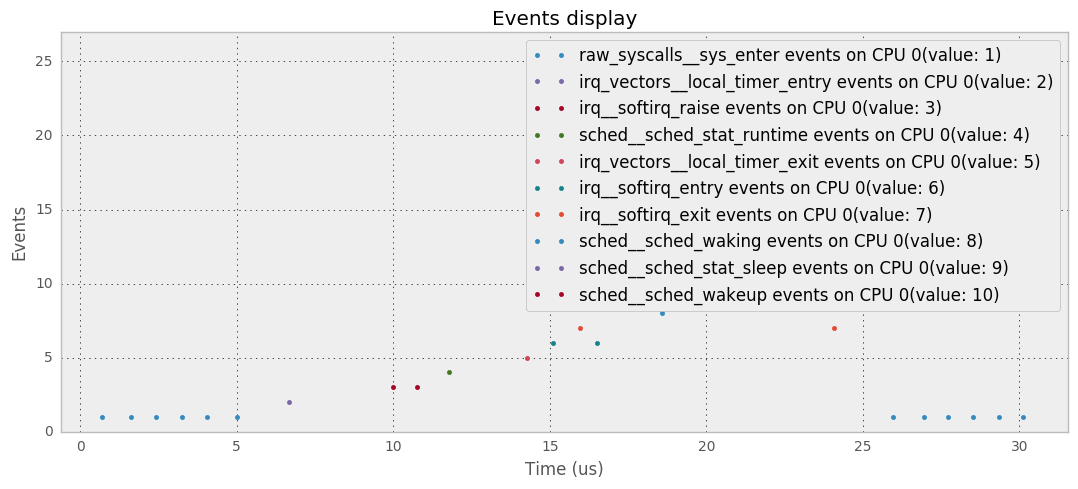

In [39]:
lps.plot_event_timeline(df, offset=(344746636 - 5000), delay=(20951 + 10000))

### Interpretation 1

Let's print again the dataframe holding the delays higher than 20us:

```
cpu                    event      nsecs  duration
0     0  raw_syscalls__sys_enter   26578460     34676
1     0  raw_syscalls__sys_enter  126653015     51477
2     0  raw_syscalls__sys_enter  226740899     49262
3     0  raw_syscalls__sys_enter  326828059     61705
4     0  raw_syscalls__sys_enter  343604954     78330
5     0  raw_syscalls__sys_enter  344746636     20951
6     0  raw_syscalls__sys_enter  426921538     56379
7     0  raw_syscalls__sys_enter  527007124     62205
8     0  raw_syscalls__sys_enter  627095293     63102
9     0  raw_syscalls__sys_enter  666979862     50127
10    0  raw_syscalls__sys_enter  727187135     50455
11    0  raw_syscalls__sys_enter  771426190     54250
```

Within this set of delays, the reader will detect 2 types: 

* Type 1: the delays which occur regularly at 27ms, 127ms, 227ms,
  etc.; here we clearly notice a 100Hz frequency.
* Type2 : the other ones which happened irregularly at 344ms, 345ms,
  667ms, etc.

Let's now focus on the graph above which corresponds to the first
sample:

* This graph shows a "Type 1" delay;
* The cause of the preemption (then the delay) is a timer interrupt
  which triggers a context switch;
* Once the context switch is performed, we loose track of what is
  happening: the perf command only registered tracepoints which
  occurred in the context of the "dd" process (and its parent bash).

Concerning the second graph above:

* This graph shows a "Type 2" delay;
* Once more, a local timer interrupt is the origin of the preemption;
  the timer triggered maybe because a process should be woken up after
  a clock_nanosleep; the tracepoint sched__sched_wakeup seems to prove
  that hypothesis.

Therefore, we can conclude, here, that some of the high delays are due
to preemption; but are these preemptions the origin of a part of the
delays or all of them ? We need one more tests to answer this
question, let's only compute the delays between 2 contiguous
raw_syscalls__sys_enter tracepoints (the raw_syscalls__sys_enter
tracepoints are contiguous when no preemption-related tracepoints
occurred between them).

### One more test

Let's print and plot the statistics of delays between 2 contiguous
raw_syscalls__sys_enter tracepoints:

Time interval statistics from raw_syscalls__sys_enter to raw_syscalls__sys_enter :
CPU 0


count   1,537,883.00
mean          485.70
std           122.66
min           433.00
25%           453.00
50%           479.00
75%           484.00
max        15,978.00
Name: duration, dtype: float64
CPU 1


count   4,430,125.00
mean          500.23
std           143.23
min           407.00
25%           450.00
50%           477.00
75%           483.00
max        19,035.00
Name: duration, dtype: float64
CPU 2


count   31,011.00
mean       786.00
std        331.75
min        410.00
25%        743.00
50%        808.00
75%        849.00
max     11,481.00
Name: duration, dtype: float64


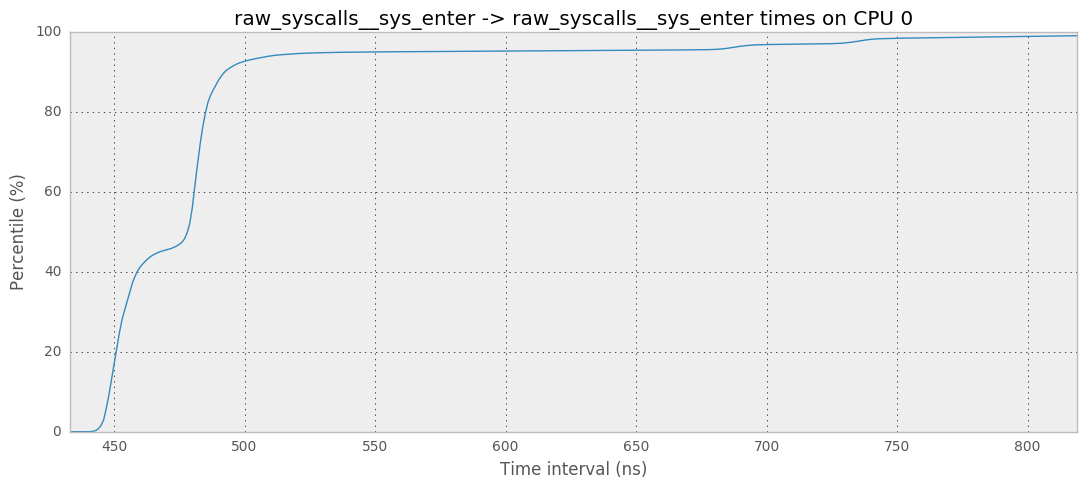

In [11]:
lps.print_event_intervals(df, 'raw_syscalls__sys_enter', 'raw_syscalls__sys_enter')
lps.plot_event_intervals(df, 'raw_syscalls__sys_enter', 'raw_syscalls__sys_enter', cpu=0)

In [17]:
print 'More percentile values on CPU 0:'
print '75.000%:', lps.get_event_itv_quantile(df, 'raw_syscalls__sys_enter', 'raw_syscalls__sys_enter', quantile_value=0.75)
print '95.000%:', lps.get_event_itv_quantile(df, 'raw_syscalls__sys_enter', 'raw_syscalls__sys_enter', quantile_value=0.95)
print '99.000%:', lps.get_event_itv_quantile(df, 'raw_syscalls__sys_enter', 'raw_syscalls__sys_enter', quantile_value=0.99)
print '99.990%:', lps.get_event_itv_quantile(df, 'raw_syscalls__sys_enter', 'raw_syscalls__sys_enter', quantile_value=0.9999)
print '99.999%:', lps.get_event_itv_quantile(df, 'raw_syscalls__sys_enter', 'raw_syscalls__sys_enter', quantile_value=0.99999)

More percentile values on CPU 0:
75.000%:

 484.0
95.000%:

 561.0
99.000%:

 819.0
99.990%:

 3815.059
99.999%:

 10696.64962


In [24]:
tmp_df = df.copy()
tmp_df.nsecs -= tmp_df.nsecs.iloc[0]
tmp_df = tmp_df.loc[tmp_df.cpu == 0]
tmp_df.reset_index(drop=True, inplace=True)
tmp_df = lps.event_interval._add_intervals(tmp_df)
tmp_df = tmp_df.loc[(tmp_df.duration > 12000) &
		    (tmp_df.event == 'raw_syscalls__sys_enter') &
		    (tmp_df.next_event == 'raw_syscalls__sys_enter')]

print 'Events just before a delay > 12us:'
print tmp_df[['cpu', 'event', 'nsecs', 'duration']].reset_index(drop=True)

Events just before a delay > 12us:
   cpu                    event      nsecs  duration
0    0  raw_syscalls__sys_enter   26285134     15978
1    0  raw_syscalls__sys_enter   27703204     12549
2    0  raw_syscalls__sys_enter  359817635     13075


### Interpretation 2

Even if we skip delays due to preemption, the standard deviation is
still high: 120ns in the best case. The graph above also shows that
the 99-percentile is 820ns. Finally, we have 3 records greater than
12us.

So a part of the high delays are not due to preemptions... we have
managed to detect with tracepoints. Maybe other preemptions, like SMI
interrupts, could explain the high delays.

# Conclusion

So far, we are unable to prove that the cost of tracepoints is stable;
however we can keep in mind that:

* 75% of the recorded tracepoints had a cost lower than 381ns (483 -
  103ns);
* 95% of the recorded tracepoints had a cost lower than 458ns (561ns
  -103ns);
* 99% of the recorded tracepoints had a cost lower than 716ns (819ns
  -103ns);
* 99.99% of the recorded tracepoints had a cost lower than 3.7us
  (3815ns -103ns);

This first conclusion might be enough to define when tracepoints can
be used without modifying (too much) the traced environment.

The second point we need to keep in mind is that this study is far
from complete. We did not find out the reason the sporadic high costs;
they might be due to:

* An undetected preemption case (NMI/SMI interrupts, etc.);
* An expensive execution path in tracepoint management code seldomly
  executed;
* Something weird in read / write syscalls code (not probable).

To complete this document, it might be interesting to:

* Perform more accurate tests (dd should run in SCHED_FIFO with core affinity set);
* Disable turbo boost and/or use another CPU frequency driver (acpi)
  so as to set a constant CPU frequency.

# Annex A: statistics for the case static tracepoints syscalls:sys_enter_read and syscalls:sys_enter_write

In [26]:
fname = '/home/alexis/workspace/perf/test_dd/syscalls_read_write.h5'

# Read the DataFrame
store = pd.HDFStore(fname, mode='r')
df = store['events']
del store

# Remove the events which did not occur in dd's context
df = df.loc[df.comm == 'dd']

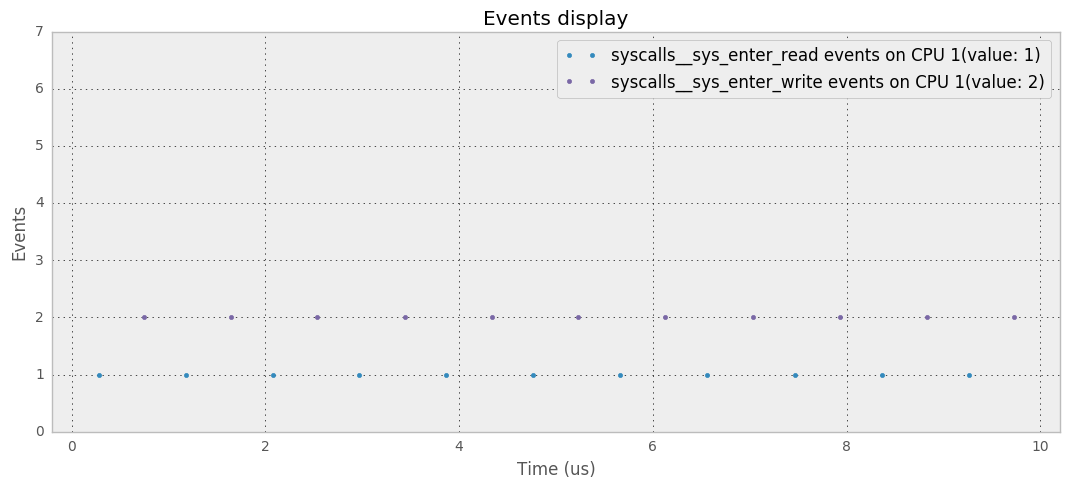

In [28]:
lps.plot_event_timeline(df, offset='1ms', delay='10us')

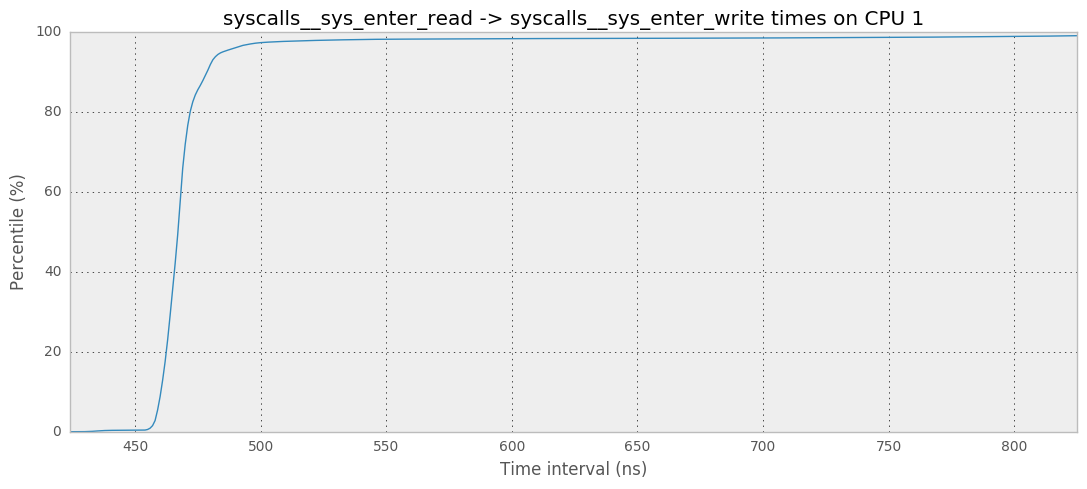

count   3,000,001.00
mean          475.56
std            76.32
min           424.00
25%           464.00
50%           468.00
75%           471.00
max        32,850.00
Name: duration, dtype: float64


Time interval statistics from syscalls__sys_enter_read to syscalls__sys_enter_write :
CPU 1


In [29]:
lps.print_event_intervals(df, 'syscalls__sys_enter_read', 'syscalls__sys_enter_write')
lps.plot_event_intervals(df, 'syscalls__sys_enter_read', 'syscalls__sys_enter_write', cpu=1)

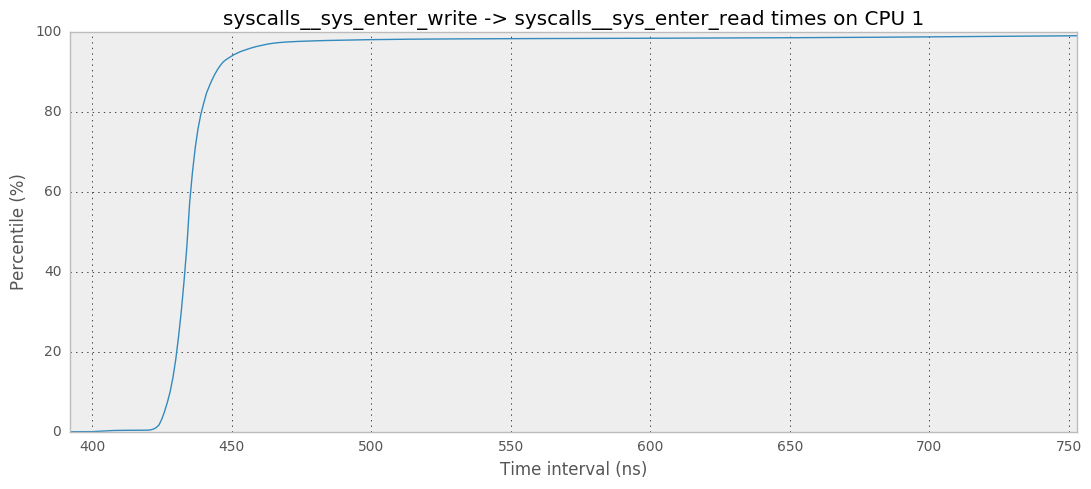

count   3,000,000.00
mean          441.95
std            75.90
min           392.00
25%           432.00
50%           435.00
75%           438.00
max        53,969.00
Name: duration, dtype: float64


Time interval statistics from syscalls__sys_enter_write to syscalls__sys_enter_read :
CPU 1


In [30]:
lps.print_event_intervals(df, 'syscalls__sys_enter_write', 'syscalls__sys_enter_read')
lps.plot_event_intervals(df, 'syscalls__sys_enter_write', 'syscalls__sys_enter_read', cpu=1)

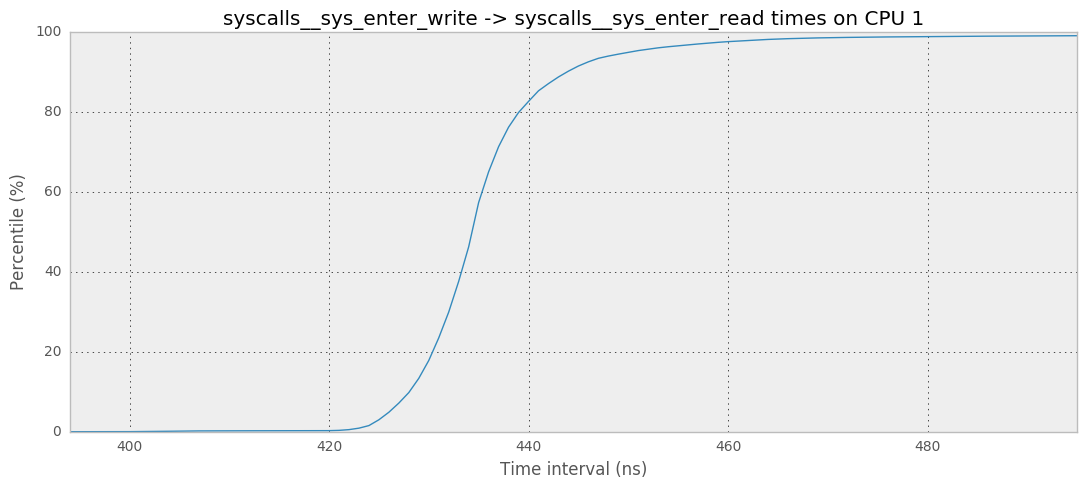

count    500000.000000
mean        438.609110
std          56.725951
min         394.000000
25%         432.000000
50%         435.000000
75%         438.000000
max       14565.000000
Name: duration, dtype: float64


count    499999.000000
mean        471.676141
std          56.609203
min         426.000000
25%         464.000000
50%         468.000000
75%         471.000000
max       18926.000000
Name: duration, dtype: float64
Time interval statistics from syscalls__sys_enter_write to syscalls__sys_enter_read :
CPU 1


Time interval statistics from syscalls__sys_enter_read to syscalls__sys_enter_write :
CPU 1


In [11]:
sub_df = df.iloc[1000000:2000000]
lps.print_event_intervals(sub_df, 'syscalls__sys_enter_write', 'syscalls__sys_enter_read')
lps.plot_event_intervals(sub_df, 'syscalls__sys_enter_write', 'syscalls__sys_enter_read', cpu=1)

# Annex B: statistics for the case dynamic probes probe__sys_read and probe__sys_write

In [3]:
fname = '/home/alexis/workspace/perf/test_dd/kprobe_syscalls_read_write.h5'

# Read the DataFrame
store = pd.HDFStore(fname, mode='r')
df = store['events']
del store

# Keep only events which occurred in dd's context
df = df.loc[df.comm == 'dd']

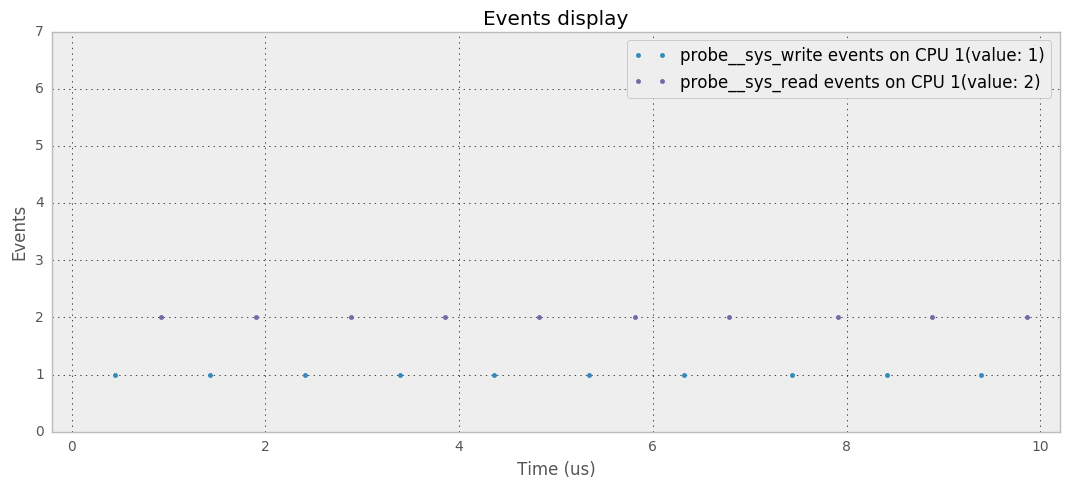

In [7]:
lps.plot_event_timeline(df, offset='1ms', delay='10us')

Time interval statistics from probe__sys_write to probe__sys_read :
CPU 1


count   3,000,000.00
mean          479.93
std            63.99
min           430.00
25%           472.00
50%           475.00
75%           478.00
max        43,561.00
Name: duration, dtype: float64


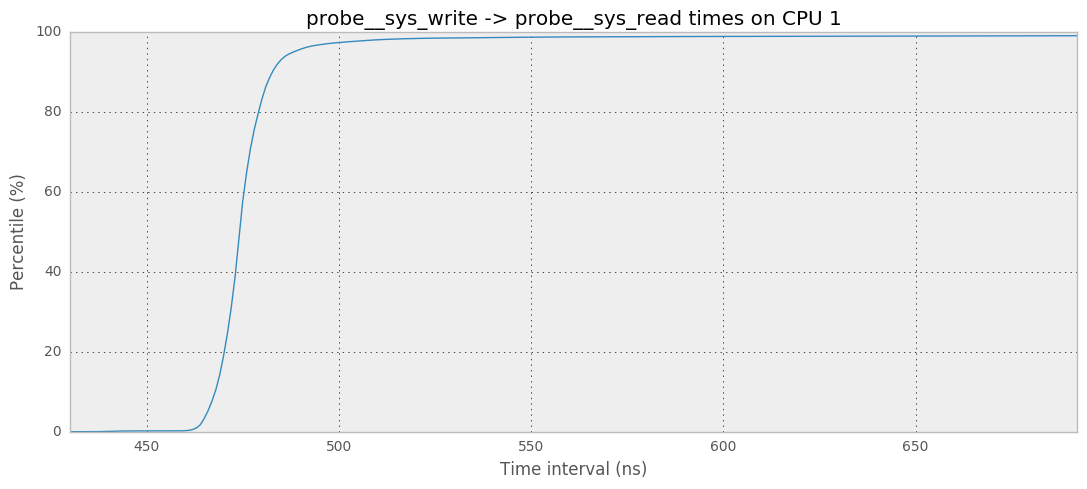

In [8]:
lps.print_event_intervals(df, 'probe__sys_write', 'probe__sys_read')
lps.plot_event_intervals(df, 'probe__sys_write', 'probe__sys_read', cpu=1)

Time interval statistics from probe__sys_read to probe__sys_write :
CPU 1


count   3,000,001.00
mean          530.56
std            67.04
min           461.00
25%           523.00
50%           527.00
75%           532.00
max        32,672.00
Name: duration, dtype: float64


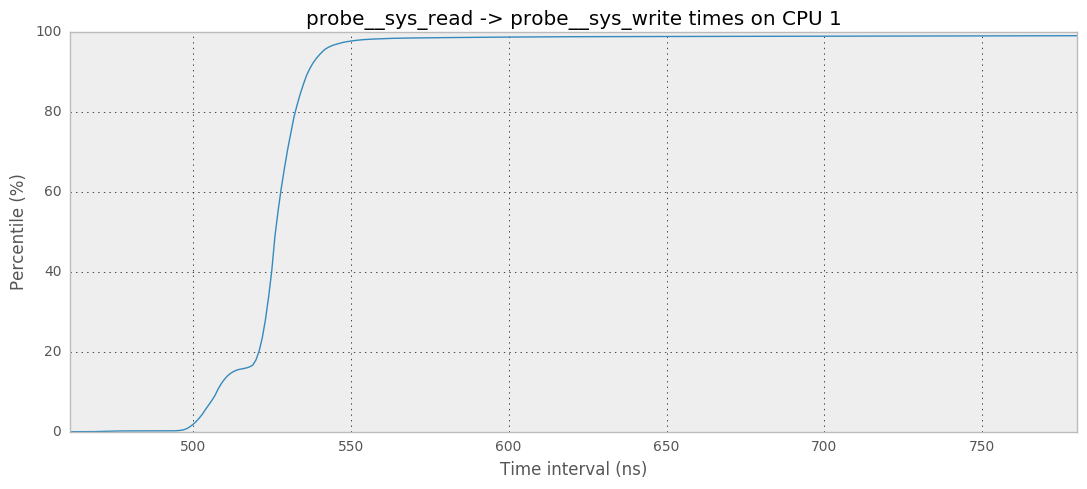

In [9]:
lps.print_event_intervals(df, 'probe__sys_read', 'probe__sys_write')
lps.plot_event_intervals(df, 'probe__sys_read', 'probe__sys_write', cpu=1)